In [16]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point




In [2]:
cnx = sqlite3.connect('FPA_FOD_20170508.sqlite')

df = pd.read_sql_query("SELECT * FROM Fires", cnx)

In [3]:
df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [4]:
df = df.loc[df.STATE == "CO",:]

print(df.columns)

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')


In [5]:
print(df.FIRE_YEAR)

47         2005
61         2005
62         2005
114        2005
205        2005
           ... 
1860039    2015
1860043    2015
1860044    2015
1860048    2015
1860054    2015
Name: FIRE_YEAR, Length: 34157, dtype: int64


In [6]:
fires = df[["FOD_ID", "FIRE_YEAR", "FIRE_SIZE", "DISCOVERY_DOY", "DISCOVERY_TIME",
           "STAT_CAUSE_CODE", "STAT_CAUSE_DESCR", "CONT_DOY", "CONT_TIME", "FIRE_SIZE",
            "LATITUDE", "LONGITUDE", "STATE"]]
fires.head()

,FOD_ID,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DOY,CONT_TIME,FIRE_SIZE,LATITUDE,LONGITUDE,STATE
47,48,2005,0.5,165,1300,1.0,Lightning,165.0,1530,0.5,39.292222,-105.183056,CO
61,62,2005,0.2,150,1100,1.0,Lightning,151.0,1218,0.2,38.913333,-105.983611,CO
62,63,2005,0.1,172,1241,4.0,Campfire,172.0,1506,0.1,39.100278,-106.367500,CO
114,117,2005,80.0,188,1907,1.0,Lightning,188.0,2130,80.0,37.345000,-102.805833,CO
205,209,2005,2.5,164,1428,9.0,Miscellaneous,164.0,1736,2.5,38.891111,-105.431944,CO


In [13]:
#Data Visualization

coMap = gpd.read_file("Colorado_County_Boundaries\\Colorado_County_Boundaries.shp")

<AxesSubplot:>

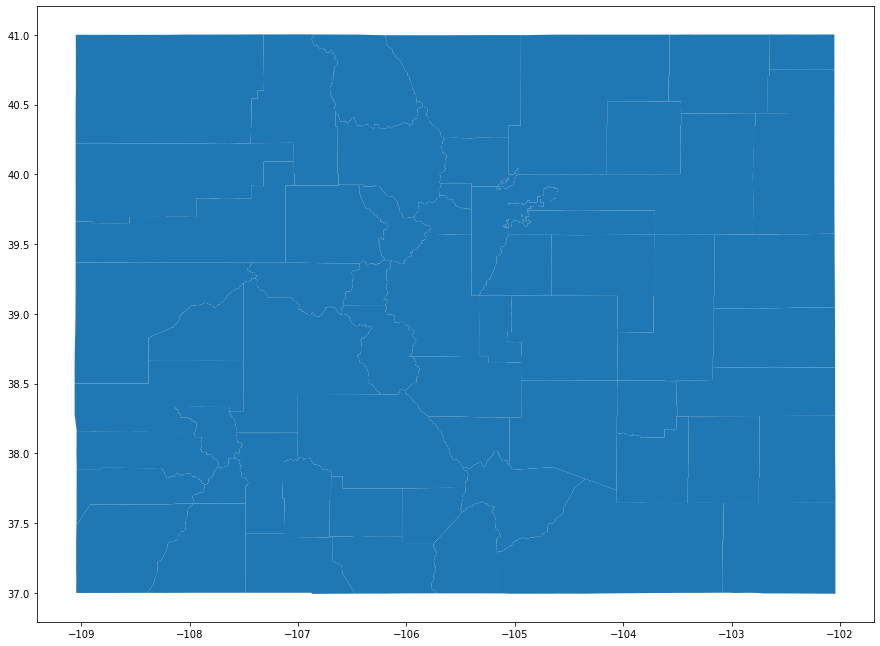

In [30]:
fig, ax = plt.subplots(figsize = (15,15))
coMap.plot(ax = ax)

1789490        0
1789491        0
1789492        0
1789493        0
1789494        0
           ...  
1860039      500
1860043      610
1860044      270
1860048    11699
1860054      120
Name: FIRE_SIZE, Length: 591, dtype: int32
1789490        0.1
1789491        0.1
1789492        0.1
1789493        0.2
1789494        0.1
            ...   
1860039      500.0
1860043      610.0
1860044      270.0
1860048    11699.0
1860054      120.0
Name: FIRE_SIZE, Length: 591, dtype: float64


<AxesSubplot:>

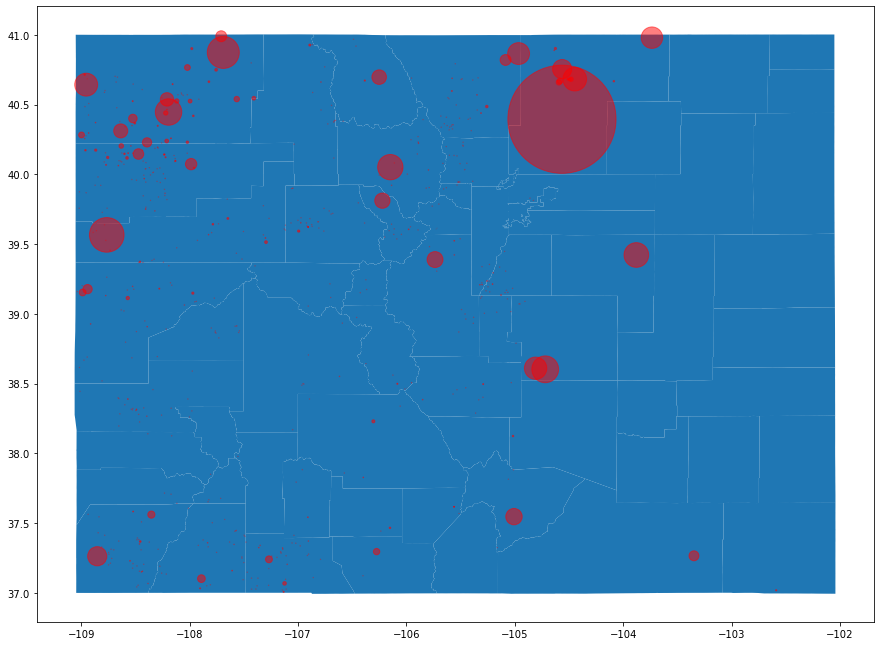

In [75]:
fires2015 = fires.loc[fires.FIRE_YEAR == 2015,:]

fig2, ax2 = plt.subplots(figsize = (15,15))
crs = "EPSG:4326"
geometry = [Point(xy) for xy in zip(fires2015.LONGITUDE, fires2015.LATITUDE)]

geo_df = gpd.GeoDataFrame(fires2015, crs = crs, geometry = geometry)

markerSize = fires2015.FIRE_SIZE.astype(int)
print(markerSize.iloc[:,1])
print(geo_df['FIRE_SIZE'].iloc[:,1])
coMap.plot(ax = ax2)
geo_df.plot(ax = ax2, markersize = geo_df['FIRE_SIZE'].iloc[:,1], color = 'red', alpha = .5)


In [82]:
fires2015.loc[fires2015['FIRE_SIZE'].idxmax()]

,FOD_ID,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DOY,CONT_TIME,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,geometry
1860048,300293901,2015,11699.0,261,1305,13.0,Missing/Undefined,NaN,None,11699.0,40.3947,-104.5646,CO,POINT (-104.56460 40.39470)
1860048,300293901,2015,11699.0,261,1305,13.0,Missing/Undefined,NaN,None,11699.0,40.3947,-104.5646,CO,POINT (-104.56460 40.39470)


In [44]:
#coMap.plot(ax = ax)

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>